# Imports

In [6]:
import os, time, sys
import zipfile
import csv
import math, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

from timeit import default_timer as timer
import joblib
import h5py

import tensorflow as tf
import tensorflowjs as tfjs

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# BoundingBox Packer Class


In [7]:

class BinPackerNode:
    def __init__(self, x=0, y=0, width=0,height=0, data=None, left=None,right=None):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.data = data
        self.left = left
        self.right = right

    def split(self, data, width, height):
        self.data = data
        self.left = BinPackerNode(self.x,self.y+height, self.width, self.height-height)
        self.right = BinPackerNode(self.x+width,self.y, self.width-width, height)
        return self
    
    @staticmethod
    def find(node, width, height):
        if node.data:
            return BinPackerNode.find(node.right, width, height) or BinPackerNode.find(node.left, width, height)
        elif width <= node.width and height <= node.height:
            return node
        return None


class BinPacker:
    def __init__(self, width, height):
        self.root = BinPackerNode(0,0,width,height)
    
    cbsort = {
        "w": (lambda a,b: b["width"] - a["width"]),
        "h": (lambda a,b: b["height"] - a["height"]),
        "a": (lambda a,b: b["width"]*b["height"] - a["width"]*a["height"]),
        "max": (lambda a,b: max(b["width"], b["height"]) - max(a["width"], a["height"])),
        "min": (lambda a,b: min(b["width"], b["height"]) - min(a["width"], a["height"])),
        "random": (lambda a,b: random.random() - 0.5),
        "height": (lambda a,b: BinPacker.msort(a, b, ['h','w'])),
        "width": (lambda a,b: BinPacker.msort(a, b, ['w','h'])),
        "area": (lambda a,b: BinPacker.msort(a, b, ['a','h','w'])),
        "maxside": (lambda a,b: BinPacker.msort(a, b, ['max','min','h','w'])),
    }
    
    @staticmethod
    def msort(a, b, criteria):
        diff = 0
        for n in range(len(criteria)):
            diff = BinPacker.cbsort[criteria[n]](a,b)
            if diff != 0:
                break
        return diff
    
    @staticmethod
    def swap(a,i,j):
        t = a[i]
        a[i] = a[j]
        a[j] = t

    @staticmethod
    def sort(arr, criteria = ['height']):
        for i in range(0, len(arr)-1):
            for j in range(i+1, len(arr)):
                if BinPacker.msort(arr[i], arr[j], criteria) > 0:
                    BinPacker.swap(arr,i,j)

    def fit(self, blocks_src, criteria = ['height']):
        res = []
        blocks = []
        
        for i in range(len(blocks_src)):
            blocks.append(blocks_src[i])

        BinPacker.sort(blocks, criteria)

        for i in range(len(blocks)):
            block = blocks[i]
            w = block["width"]
            h = block["height"]
            node = BinPackerNode.find(self.root, w,h)
            if not node:
                continue
            if not node.split(block["data"] if "data" in block else "empty", w,h):
                continue
            node.width = w
            node.height = h
            res.append(node)
        return res

## Exemple:


In [ ]:
blocks = [
    { "width": 100, "height": 100, "data": {"color":0xff0000} },
    { "width": 100, "height": 100, "data": {"color":0x0000ff} },
    { "width":  80, "height":  80 },
    { "width":  80, "height":  80, "data": {"color":0x0} },
]
packer = BinPacker(300,300)
res = packer.fit(blocks, ["area"])

for i in range(len(res)):
    node = res[i]
    if node.data == "empty":
        
        continue
    color = node.data["color"]
    print(node.x, node.y, node.width, node.height, color)

# Generic Class for multiclass objects detection


In [70]:
class ObjectDetectionGenerator:
    def __init__(self, X_train, y_train, X_test, y_test, dir_path, labels=[],
                 layers_width=300, layers_height=300,
                 random_state=1, test_size=0.25):
        self.random_state = random_state
        self.layers_width = layers_width
        self.layers_height = layers_height
        self.labels = labels
        self.max_object_count = 10 # max objects per layer
        
        self.objects = {
            "X_train": X_train, "y_train_id": y_train, "y_train_bbox": [],
            "X_val": [], "y_val_id": [], "y_val_bbox": [],
            "X_test": X_test, "y_test_id": y_test, "y_test_bbox": [],
        }
        self.layers = { # sprites composition
            "X_train": None, "y_train_id": None, "y_train_bbox": None,
            "X_val": None, "y_val_id": None, "y_val_bbox": None,
            "X_test": None, "y_test_id": None, "y_test_bbox": None,
        }
        
        self.dir_path = dir_path
        self.dir_path_origin = os.path.join(self.dir_path, 'origin')
        self.dir_path_enhanced = os.path.join(self.dir_path, 'enhanced')
        
        # set arrays type
        l = self.layers
        (l["X_train"],l["y_train_id"],l["y_train_bbox"]) = self.set_X_y()
        (l["X_val"],l["y_val_id"],l["y_val_bbox"]) = self.set_X_y()
        (l["X_test"],l["y_test_id"],l["y_test_bbox"]) = self.set_X_y()
        
        s = self.objects
        (s["X_train"], s["X_val"],
         s["y_train_id"], s["y_val_id"]) = train_test_split(X_train, y_train,
                                                            test_size=test_size,
                                                            random_state=random_state)
        
    css_colors = {
        "AliceBlue": "F0F8FF", "AntiqueWhite": "FAEBD7", "Aqua": "00FFFF",
        "Aquamarine": "7FFFD4", "Azure": "F0FFFF", "Beige": "F5F5DC",
        "Bisque": "FFE4C4", "Black": "000000", "BlanchedAlmond": "FFEBCD",
        "Blue": "0000FF", "BlueViolet": "8A2BE2", "Brown": "A52A2A",
        "BurlyWood": "DEB887", "CadetBlue": "5F9EA0", "Chartreuse": "7FFF00",
        "Chocolate": "D2691E", "Coral": "FF7F50", "CornflowerBlue": "6495ED",
        "Cornsilk": "FFF8DC", "Crimson": "DC143C", "Cyan": "00FFFF",
        "DarkBlue": "00008B", "DarkCyan": "008B8B", "DarkGoldenRod": "B8860B",
        "DarkGray": "A9A9A9", "DarkGreen": "006400", "DarkKhaki": "BDB76B",
        "DarkMagenta": "8B008B", "DarkOliveGreen": "556B2F", "Darkorange": "FF8C00",
        "DarkOrchid": "9932CC", "DarkRed": "8B0000", "DarkSalmon": "E9967A",
        "DarkSeaGreen": "8FBC8F", "DarkSlateBlue": "483D8B", "DarkSlateGray": "2F4F4F",
        "DarkTurquoise": "00CED1", "DarkViolet": "9400D3", "DeepPink": "FF1493",
        "DeepSkyBlue": "00BFFF", "DimGray": "696969", "DodgerBlue": "1E90FF",
        "FireBrick": "B22222", "FloralWhite": "FFFAF0", "ForestGreen": "228B22",
        "Fuchsia": "FF00FF", "Gainsboro": "DCDCDC", "GhostWhite": "F8F8FF",
        "Gold": "FFD700", "GoldenRod": "DAA520", "Gray": "808080",
        "Green": "008000", "GreenYellow": "ADFF2F", "HoneyDew": "F0FFF0",
        "HotPink": "FF69B4", "IndianRed": "CD5C5C", "Indigo": "4B0082",
        "Ivory": "FFFFF0", "Khaki": "F0E68C", "Lavender": "E6E6FA",
        "LavenderBlush": "FFF0F5", "LawnGreen": "7CFC00", "LemonChiffon": "FFFACD",
        "LightBlue": "ADD8E6", "LightCoral": "F08080", "LightCyan": "E0FFFF",
        "LightGoldenRodYellow": "FAFAD2", "LightGrey": "D3D3D3", "LightGreen": "90EE90",
        "LightPink": "FFB6C1", "LightSalmon": "FFA07A", "LightSeaGreen": "20B2AA",
        "LightSkyBlue": "87CEFA", "LightSlateGray": "778899", "LightSteelBlue": "B0C4DE",
        "LightYellow": "FFFFE0", "Lime": "00FF00", "LimeGreen": "32CD32",
        "Linen": "FAF0E6", "Magenta": "FF00FF", "Maroon": "800000",
        "MediumAquaMarine": "66CDAA", "MediumBlue": "0000CD", "MediumOrchid": "BA55D3",
        "MediumPurple": "9370D8", "MediumSeaGreen": "3CB371", "MediumSlateBlue": "7B68EE",
        "MediumSpringGreen": "00FA9A", "MediumTurquoise": "48D1CC",
        "MediumVioletRed": "C71585", "MidnightBlue": "191970", "MintCream": "F5FFFA",
        "MistyRose": "FFE4E1", "Moccasin": "FFE4B5", "NavajoWhite": "FFDEAD",
        "Navy": "000080", "OldLace": "FDF5E6", "Olive": "808000", "OliveDrab": "6B8E23",
        "Orange": "FFA500", "OrangeRed": "FF4500", "Orchid": "DA70D6",
        "PaleGoldenRod": "EEE8AA", "PaleGreen": "98FB98", "PaleTurquoise": "AFEEEE",
        "PaleVioletRed": "D87093", "PapayaWhip": "FFEFD5", "PeachPuff": "FFDAB9",
        "Peru": "CD853F", "Pink": "FFC0CB", "Plum": "DDA0DD", "PowderBlue": "B0E0E6",
        "Purple": "800080", "Red": "FF0000", "RosyBrown": "BC8F8F", "RoyalBlue": "4169E1",
        "SaddleBrown": "8B4513", "Salmon": "FA8072", "SandyBrown": "F4A460",
        "SeaGreen": "2E8B57", "SeaShell": "FFF5EE", "Sienna": "A0522D",
        "Silver": "C0C0C0", "SkyBlue": "87CEEB", "SlateBlue": "6A5ACD",
        "SlateGray": "708090", "Snow": "FFFAFA", "SpringGreen": "00FF7F",
        "SteelBlue": "4682B4", "Tan": "D2B48C", "Teal": "008080", "Thistle": "D8BFD8",
        "Tomato": "FF6347", "Turquoise": "40E0D0", "Violet": "EE82EE", "Wheat": "F5DEB3",
        "White": "FFFFFF", "WhiteSmoke": "F5F5F5", "Yellow": "FFFF00", "YellowGreen": "9ACD32"
    }
    
    @staticmethod
    def list_first_val(arr):
        for i in arr:
            if i > 0:
                return 1
        return -1
    
    @staticmethod
    def get_bbox(data):
        """aligned-axis bounding-box (bounding square)"""
        x1 = 0xffff
        y1 = 0xffff
        x2 = 0
        y2 = 0
        # y1
        for j in range(len(data)):
            if ObjectDetectionGenerator.list_first_val(data[j]) > 0:
                y1 = j
                break
        # y2
        for j in range(len(data)):
            end = len(data)-j-1
            if ObjectDetectionGenerator.list_first_val(data[end]) > 0:
                y2 = end
                break
        # x1, x2
        for j in range(len(data)):
            ydata = data[j]
            val = 0xffff
            last = 0
            for i in range(len(ydata)):
                if ydata[i] > 0:
                    x1 = min(x1,i)
                    x2 = max(x2,i)
        return np.array([x1,y1, x2+1,y2+1])

    @staticmethod
    def get_X_bbox(X):
        bboxes = []
        for i in range(len(X)):
            bboxes.append(ObjectDetectionGenerator.get_bbox(X[i]))
            #if i > 10: break
        return bboxes
    
    @staticmethod
    def read_bbox_csv(dir_path, filename):
        file_path = os.path.join(dir_path, filename)
        df = pd.read_csv(file_path)
        return np.array(list(df.itertuples(index=False, name=None)))

    @staticmethod
    def write_bbox_csv(dir_path, filename, X):
        file_path = os.path.join(dir_path, filename)
        bbox = ObjectDetectionGenerator.get_X_bbox(X)
        df = pd.DataFrame(bbox, columns=['x1','y1','x2','y2'])
        df.to_csv(file_path, index=False)
        return bbox

    @staticmethod
    def scaling2D(X_train, X_val, X_test, div=[1,1]):
        mat2_div = np.array([div[0],div[1],div[0],div[1]])
        X_train_scaled = X_train / mat2_div
        X_val_scaled = X_val / mat2_div
        X_test_scaled = X_test / mat2_div
        return X_train_scaled, X_val_scaled, X_test_scaled
    
    @staticmethod
    def _draw_object(src, sx,sy, s_width,s_height,
                     dst, dx,dy, d_width,d_height):
        # src
        s_width_orig = src.shape[1]
        s_height_orig = src.shape[0]
        # dst
        d_width_orig = dst.shape[1]
        d_height_orig = dst.shape[0]
        dx -= sx
        dy -= sy
        for j in range(sy,s_height):
            for i in range(sx,s_width):
                color = src[j][i]
                dst[j+dy][i+dx] = color# if color else 127
        return
    
    @staticmethod
    def _bbox_collide_bbox_list(x,y, bbox, pos_list,bbox_list):
        if len(bbox_list) == 0:
            return False
        a = bbox
        for i in range(len(bbox_list)):
            x2 = pos_list[i][0]
            y2 = pos_list[i][1]
            b = bbox_list[i]
            if a[2]+x < b[0]+x2 or a[0]+x > b[2]+x2:
                continue
            if a[3]+y < b[1]+y2 or a[1]+y > b[3]+y2:
                continue
            return True
        return False
    
    @staticmethod
    def _plt_rectangle(tup, color_id=0, text="None"):
        x1 = tup[0]
        y1 = tup[1]
        x2 = tup[2]
        y2 = tup[3]
        # body
        color = '#' + list(ObjectDetectionGenerator.css_colors.values())[color_id]
        rec_body = Rectangle((x1-0.5,y1-0.5),x2-x1,y2-y1,
                             linewidth=4,edgecolor=color,facecolor='none')
        plt.gca().add_patch(rec_body)
        # title
        if text != "None":
            bbox = dict(edgecolor='none', facecolor=color)
            plt.text(x1-0.5, y1-1.5, text,  color="black",
                     ha="left", va="bottom", fontsize=30, bbox=bbox)
        return
    
    @staticmethod
    def read_json_array(path):
        with open(path) as f:
            data = json.load(f)
        return np.asarray(data)
    
    @staticmethod
    def write_json_array(path, array):
        np.set_printoptions(threshold=1000000000)
        json_str = np.array2string(array, precision=2, separator=',')
        with open(path, 'w', encoding='utf-8') as f:
            f.write(json_str)
        np.set_printoptions(threshold=1000)
        return

    @staticmethod
    def zipdir(path, ziph):
        for root, dirs, files in os.walk(path):
            for file in files:
                root_file = os.path.join(root, file)
                ziph.write(root_file, os.path.relpath(root_file, os.path.join(path, '..')))
        return

    def set_X_y(self, dim=0):
        height = self.layers_height
        width = self.layers_width
        return (np.zeros((dim, height, width, 1), dtype="float32"),
                np.full((dim, self.max_object_count), -1, dtype="int8"), # id
                np.zeros((dim, self.max_object_count, 4), dtype="int16")) # bbox
                
    def append_X_y(self, X_set, y_set_id, y_set_bbox):
        arrays = self.set_X_y(1)
        return (np.append(X_set, arrays[0], axis=0),
                np.append(y_set_id, arrays[1], axis=0),
                np.append(y_set_bbox, arrays[2], axis=0))
    
    def load_objects(self, gen_files=True, test_size=0.25, random_state=1):
        """
        - convert csv to png
        - load or generate+save aabb's
        """
        s = self.objects
        dir_origin = self.dir_path_origin
        
        if (not gen_files) or dir_origin == None:
            s["y_train_bbox"] = self.get_X_bbox(s["X_train"])
            s["y_val_bbox"] = self.get_X_bbox(s["X_val"])
            s["y_test_bbox"] = self.get_X_bbox(s["X_test"])
            return
        # folder exists ?
        if not os.path.exists(dir_origin):
            os.makedirs(dir_origin)
        # load aabb
        if os.path.exists(os.path.join(dir_origin, 'y_train_bbox.csv')):
            s["y_train_bbox"] = self.read_bbox_csv(dir_origin, 'y_train_bbox.csv')
            s["y_val_bbox"] = self.read_bbox_csv(dir_origin, 'y_val_bbox.csv')
            s["y_test_bbox"] = self.read_bbox_csv(dir_origin, 'y_test_bbox.csv')
            print("bbox CSVs loaded")
        else: # or compute them (slow!)
            print("BBOXes generation of the dataset... (it can take a while)")
            s["y_train_bbox"] = self.write_bbox_csv(dir_origin, 'y_train_bbox.csv', s["X_train"])
            s["y_val_bbox"] = self.write_bbox_csv(dir_origin, 'y_val_bbox.csv', s["X_val"])
            s["y_test_bbox"] = self.write_bbox_csv(dir_origin, 'y_test_bbox.csv', s["X_test"])
            print("bbox CSVs computed & saved")

        with zipfile.ZipFile(dir_origin+'.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
            self.zipdir(dir_origin, zipf)
        return self

    def write_layers(self, X_set="train"):
        dir_path_layers = os.path.join(self.dir_path_enhanced, X_set)
        X_set = "X_" + X_set
        images_len = len(self.layers[X_set])
        for i in range(images_len):
            png_filename = os.path.join(dir_path_layers, f"{X_set}_{i}.png")
            pixels = np.reshape(self.layers[X_set][i],(self.layers_height,self.layers_width))
            img = Image.fromarray(pixels.astype(np.uint8), mode='L')
            img.save(png_filename, format='PNG', bits=8)
        print(f"{images_len} layers images written!")
        return self

    def read_layers(self, X_set="train"):
        dir_path_layers = os.path.join(self.dir_path_enhanced, X_set)
        i = 0
        X_set = "X_" + X_set
        shape = (self.layers_height, self.layers_width, 1)
        arr = []
        while True:
            png_filename = os.path.join(dir_path_layers, f"{X_set}_{i}.png")
            if not os.path.exists(png_filename):
                break
            img = Image.open(png_filename)
            arr.append(np.reshape(img.getdata(),shape))
            i += 1
        self.layers[X_set] = np.array(arr)
        print(f"{i} layers images readed!")
        return self

    def load_layers(self, X_set="train", count=-1):
        l = self.layers
        dir_path_layers_set = os.path.join(self.dir_path_enhanced, X_set)
        # folders exists ?
        if not os.path.exists(dir_path_layers_set):
            os.makedirs(dir_path_layers_set)

        json_id_filename = f'layers_y_id_{X_set}.json'
        json_id_filepath = os.path.join(dir_path_layers_set, json_id_filename)
        json_bbox_filename = f'layers_y_bbox_{X_set}.json'
        json_bbox_filepath = os.path.join(dir_path_layers_set, json_bbox_filename)

        if not os.path.exists(json_id_filepath):
            # read json png's / id's / bbox
            self.write_layers(X_set)
            self.write_json_array(json_id_filepath, l[f"y_{X_set}_id"])
            self.write_json_array(json_bbox_filepath, l[f"y_{X_set}_bbox"])
            print(f'"{X_set}" png and bbox saved!')
        else:
            self.reset_layer(X_set)
            # read json png's / id's / bbox
            self.read_layers(X_set)
            l[f"y_{X_set}_id"] = self.read_json_array(json_id_filepath)
            l[f"y_{X_set}_bbox"] = self.read_json_array(json_bbox_filepath)
            print(f'"{X_set}" png and bbox loaded!')
        return
    
    def zip_folder_datasets(self):
        path = self.dir_path_enhanced
        with zipfile.ZipFile(path+'.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
            self.zipdir(path, zipf)
        return self
    
    def reset_layer(self, X_set):
        l = self.layers
        (l[f"X_{X_set}"], l[f"y_{X_set}_id"], l[f"y_{X_set}_bbox"]) = self.set_X_y()
        return self

    def reset_layers(self):
        self.reset_layer("train").reset_layer("val").reset_layer("test")
        return self
    
    def clean_layer(self, X_set="train", layer_idx=0):
        l = self.layers
        idx = layer_idx
        y_set = "y_" + X_set
        X_set = "X_" + X_set
        if len(l[X_set]) > idx:
            (l[X_set][idx], l[y_set+"_id"][idx], l[y_set+"_bbox"][idx]) = self.set_X_y()
        return self
    
    def add_layer(self, X_set="train"):
        l = self.layers
        y_set = "y_" + X_set
        X_set = "X_" + X_set
        (l[X_set],
         l[y_set+"_id"],
         l[y_set+"_bbox"]) = self.append_X_y(l[X_set],l[y_set+"_id"],l[y_set+"_bbox"])
        return self

    def layer_draw_random_object(self, X_set="train",
                                 layer_idx=0, sprite_idx=0, x=None, y=None):
        l = self.layers
        s = self.objects
        y_set = "y_" + X_set
        X_set = "X_" + X_set
        dst = l[X_set][layer_idx]
        src = s[X_set][sprite_idx]
        bbox = s[y_set+'_bbox'][sprite_idx]
        
        if x == None:
            x = random.randint(0, self.layers_width-bbox[2])
        if y == None:
            y = random.randint(0, self.layers_height-bbox[3])
        
        buckets = np.where(l[y_set+"_id"][layer_idx]  == -1)[0]
        if len(buckets) == 0:
            print("Too many sprites!")
            return
        layer_sprite_idx = buckets[0]
        # id
        l[y_set+"_id"][layer_idx, layer_sprite_idx] = s[y_set+'_id'][sprite_idx]
        # bbox
        bbox_in_layer = np.array([x,y, x+(bbox[2]-bbox[0]), y+(bbox[3]-bbox[1])])
        l[y_set+"_bbox"][layer_idx, layer_sprite_idx] = bbox_in_layer
        # image
        self._draw_object(src, bbox[0],bbox[1], bbox[2],bbox[3],
                          dst, x,y, dst.shape[0],dst.shape[1])
        return self
            
    def layer_draw_random_objects(self, X_set="train", layer_idx=0, count=20):
        s = self.objects
        l = self.layers
        y_set = "y_" + X_set
        X_set = "X_" + X_set
        random_call_count = 0
        dst = l['X_train'][layer_idx]
        pos_list = []
        bbox_list = []
        
        for i in range(count):
            idx = random.randint(0, len(s[X_set]))
            src = s[X_set][idx]
            bbox = s[y_set+'_bbox'][idx]
            for j in range(200):
                x = random.randint(0, self.layers_width-bbox[2])
                y = random.randint(0, self.layers_height-bbox[3])
                collision = self._bbox_collide_bbox_list(x,y, bbox, pos_list,bbox_list)
                if collision == False:
                    break
                random_call_count += 1
                if j >= 199:
                    raise NameError('Too many loops! reduce the number of chars')
            pos_list.append([x,y])
            bbox_list.append(bbox)
            self.layer_draw_random_object(layer_idx, idx, x,y)
                
            """bbox_train = np.array([x,y, x+(bbox[2]-bbox[0]), y+(bbox[3]-bbox[1])])
            self.layers["y_train_bbox"][layer_index].append(bbox_train)
            self.layers["y_train_id"][layer_index].append(self.sprites['y_train'][idx])
            self._draw_sprite(src,
                              bbox[0],bbox[1], bbox[2],bbox[3],
                              dst, x,y, dst.shape[0],dst.shape[1])"""
        return self
    
    def layer_draw_packed_objects(self, X_set="train", layer_idx=0, count=20):
        s = self.objects
        l = self.layers
        y_set = "y_" + X_set
        X_set = "X_" + X_set
        random_call_count = 0
        dst = l['X_train'][layer_idx]
        blocks = []
        x_pad = 2
        y_pad = 2
        
        for i in range(count):
            idx = random.randint(0, len(s[X_set]))
            src = s[X_set][idx]
            bbox = s[y_set+'_bbox'][idx]
            blocks.append({
                "width": (bbox[2]-bbox[0]) + x_pad,
                "height": (bbox[3]-bbox[1]) + y_pad,
                "data": {
                    "idx": idx,
                }
            })
        # packer
        packer = BinPacker(self.layers_width,self.layers_height)
        res = packer.fit(blocks, ["area"])
        
        for i in range(len(res)):
            node = res[i]
            if node.data == "empty":
                continue
            idx = node.data["idx"]
            src = s[X_set][idx]
            bbox = s[y_set+'_bbox'][idx]
            self._draw_object(src,
                              #0,0, 28,28,
                              bbox[0],bbox[1], bbox[2],bbox[3],
                              dst, node.x,node.y, dst.shape[1],dst.shape[0])
        return self
    
    def transform_scale_objects(self, scale=[1,1]):
        s = self.objects
        return self.scaling2D(s["y_train_bbox"], s["y_val_bbox"], s["y_test_bbox"], scale)
    
    def transform_scale_layers(self, scale=[1,1]):
        l = self.layers
        return self.scaling2D(l["y_train_bbox"], l["y_val_bbox"], l["y_test_bbox"], scale)
    
    def show_object(self, X_set="train", idx=0):
        X_set = "X_" + X_set
        s = self.objects
        plt.imshow(s[X_set][idx], cmap='gray')
        plt.show()
        return self
    
    def show_layer(self, X_set="train", idx=0):
        l = self.layers
        y_set = "y_" + X_set
        X_set = "X_" + X_set
        #plt.figure(figsize = (20,int(20*(self.layers_height / self.layers_width))))
        plt.figure(figsize = (20,20))
        #print(s["X_train"][idx].shape)
        #print(s["aabb_train"][idx])
        # draw layer
        plt.imshow(l[X_set][idx], cmap='gray')
        # draw aabb's
        text = None
        for i in range(len(l[y_set+"_bbox"][idx])):
            class_id = l[y_set+"_id"][idx][i]
            color_id = class_id + 10
            if len(self.labels) > 0:
                text = self.labels[class_id]
            self._plt_rectangle(l[y_set+"_bbox"][idx][i], color_id, text)
        plt.show()
        return self
    

## Exemple:

In [ ]:
"""dataset_dir = os.path.join(os.path.dirname(os.getcwd()), 'dataset')
arr = pd.read_json(dataset_dir+"/layers/test/layers_y_bbox_test.json", orient='values')
print(np.array(list(arr[0])))"""

dataset_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets')
arr = pd.read_json(dataset_dir+"/layers/test/layers_y_bbox_test.json", typ='series', orient='values')
arr = np.array(list(arr))

print(arr.shape)
print(arr)
print("\n")

print(np.reshape(arr, (-1,4)))

In [82]:
try: # python
    dataset_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..", "datasets")
except NameError: # jupyter notebook
    dataset_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets')

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
og = ObjectDetectionGenerator(X_train, y_train, X_test, y_test, dataset_dir,
                              layers_width=256,layers_height=128,
                              labels=["0","1","2","3","4","5","6","7","8","9"])
og.load_objects()
#og.transform_scale([28.,28.])

print("\n[object shape]:")
print(og.objects["y_train_bbox"].shape)
print(og.objects["y_val_bbox"].shape)
print(og.objects["y_test_bbox"].shape)
print("")

print("[layer shape]:")
print(og.layers["X_train"].shape)
print(og.layers["y_train_id"].shape)
print(og.layers["y_train_bbox"].shape)

og.add_layer("train")
og.layer_draw_random_object("train", 0, 5)
og.layer_draw_random_object("train", 0, 3)
print("\nadd one layer and two objects on it")

print("\n[new layer shape]:")
print(og.layers["X_train"].shape)
print(og.layers["y_train_id"].shape)
print(og.layers["y_train_bbox"].shape)

bbox CSVs loaded

[object shape]:
(45000, 4)
(15000, 4)
(10000, 4)

[layer shape]:
(0, 128, 256, 1)
(0, 10)
(0, 10, 4)

add one layer and two objects on it

[new layer shape]:
(1, 128, 256, 1)
(1, 10)
(1, 10, 4)


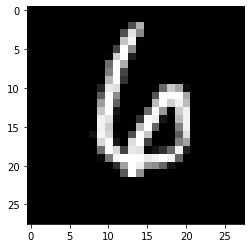

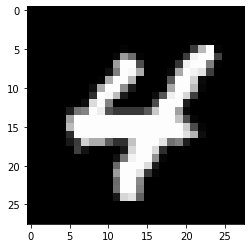

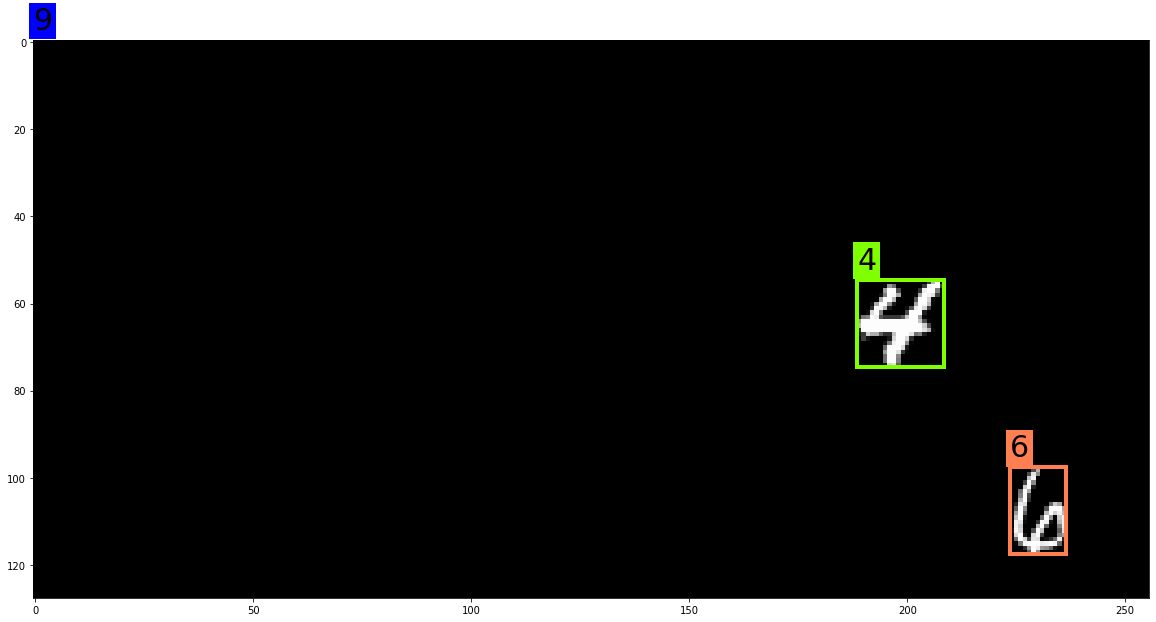

In [84]:
og.show_object(idx=5)
og.show_object(idx=3)
og.show_layer(idx=0);

## Enhanced Dataset generation + save

In [77]:
try: # python
    dataset_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..", "datasets")
except NameError: # jupyter notebook
    dataset_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets')

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
og = ObjectDetectionGenerator(X_train, y_train, X_test, y_test, dataset_dir,
                              layers_width=256,layers_height=128,
                              labels=["0","1","2","3","4","5","6","7","8","9"])
og.load_objects()
#og.transform_scale_sprites([28.,28.])

print("\ntrain:")
print(og.objects['X_train'].shape)
print(og.objects['y_train_id'].shape)
print(og.objects['y_train_bbox'].shape)
print("\nval:")
print(og.objects['X_val'].shape)
print(og.objects['y_val_id'].shape)
print(og.objects['y_val_bbox'].shape)
print("\ntest:")
print(og.objects['X_test'].shape)
print(og.objects['y_test_id'].shape)
print(og.objects['y_test_bbox'].shape)
print("")

mul = 1/100 # use 1% of dataset

for i in range(int(len(og.objects["X_train"])*mul)):
    og.add_layer("train")
    og.layer_draw_random_object("train", i, i)
og.load_layers("train")
og.reset_layers()

for i in range(int(len(og.objects["X_val"])*mul)):
    og.add_layer("val")
    og.layer_draw_random_object("val", i, i)
og.load_layers("val")
og.reset_layers()

for i in range(int(len(og.objects["X_test"])*mul)):
    og.add_layer("test")
    og.layer_draw_random_object("test", i, i)
og.load_layers("test")
og.reset_layers()

og.zip_folder_datasets()


bbox CSVs loaded

train:
(45000, 28, 28)
(45000,)
(45000, 4)

val:
(15000, 28, 28)
(15000,)
(15000, 4)

test:
(10000, 28, 28)
(10000,)
(10000, 4)

450 layers images readed!
"train" png and bbox loaded!
150 layers images readed!
"val" png and bbox loaded!
100 layers images readed!
"test" png and bbox loaded!


In [ ]:
try: # python
    dataset_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..", "dataset")
except NameError: # jupyter notebook
    dataset_dir = os.path.join(os.path.dirname(os.getcwd()), 'dataset')

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
og = ObjectDetectionGenerator(X_train, y_train, X_test, y_test, dataset_dir,
                              layers_width=256,layers_height=128,
                              labels=["0","1","2","3","4","5","6","7","8","9"])
og.load_sprites()
#og.transform_scale([28.,28.])

#og.reset_layers()
#og.add_layer()
#og.layer_draw_random_sprites(0, 2)
#og.add_layer()
#og.layer_draw_random_sprites(1, 5)


    
#og.show_layer(0)
#og.show_layer(1)

#print(og.layers["aabb_train"])
#print(pd.Series(og.layers["aabb_train"]).to_json(orient='values'))

og.load_layers("train")
og.load_layers("val")
og.load_layers("test")

#og.show_layer("test", 0)
#og.show_layer("test", 1)


#print(og.layers['X_test'].shape)
"""print(og.layers['y_test_bbox'].shape)
print(og.layers['y_test_bbox'][0])
print(og.layers['y_test_bbox'])"""
#print(og.layers['y_test_bbox'].shape)


In [ ]:
print("\ntrain:")
print(og.layers['X_train'].shape)
print(og.layers['y_train_id'].shape)
print(og.layers['y_train_bbox'].shape)
print("\nval:")
print(og.layers['X_val'].shape)
print(og.layers['y_val_id'].shape)
print(og.layers['y_val_bbox'].shape)
print("\ntest:")
print(og.layers['X_test'].shape)
print(og.layers['y_test_id'].shape)
print(og.layers['y_test_bbox'].shape)

print("\n")
#print(og.layers['X_test'][0])
#print(og.layers['y_test_id'][0])
#print(og.layers['y_test_bbox'])

print(og.layers['y_test_bbox'][0].shape)
print(np.squeeze(og.layers['y_test_bbox']))
#print(np.expand_dims(og.layers['y_test_bbox'], axis=1))

to_categorical(og.layers['y_test_id'], num_classes=10, dtype ="uint8")


In [ ]:
og.clean_layer(0)
og._draw_packed_sprites(0, 100)
og.show_layer(0)

In [ ]:
og.reset_layers()
og.add_layer()
og._draw_random_sprites(0, 1)
og.show_layers()

# Trainer Class

In [19]:

class Trainer():
    def __init__(self, canvas_width=300, canvas_height=300):
        self.canvas_width = canvas_width
        self.canvas_heigth = canvas_height
        
        self.X_train = None
        self.y_train = [None,None]
        
        self.X_val = None
        self.y_val = [None,None]
        
        self.X_test = None
        self.y_test = [None,None]
        
        
    """def scaling(self):
        self.mean_scaler = 0
        self.std_scaler = 255.

        self.X_train = (self.X_train - self.mean_scaler) / self.std_scaler
        self.X_val = (self.X_val - self.mean_scaler) / self.std_scaler
        self.X_test = (self.X_test - self.mean_scaler) / self.std_scaler
        return self"""
    
    
    def get_data(self, random_state=1, test_size=0.25):
        """(self.X_train, self.y_train[0]), (self.X_test, self.y_test[0]) = datasets.mnist.load_data(path="mnist.npz")"""
        
        try: # python
            dataset_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..", "dataset")
        except NameError: # jupyter notebook
            dataset_dir = os.path.join(os.path.dirname(os.getcwd()), 'dataset')

        (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
        self.og = ObjectDetectionGenerator(X_train, y_train, X_test, y_test, dataset_dir,
                                           layers_width=256,layers_height=128,
                                           labels=["0","1","2","3","4","5","6","7","8","9"])
        self.og.load_layers("train")
        self.og.load_layers("val")
        self.og.load_layers("test")

        # add a dim: (28, 28) -> (28, 28, 1)
        # np.expand_dims(X_train, axis=-1)
        """self.X_train = self.X_train.reshape(len(self.X_train), 28,28,1)
        self.X_test = self.X_test.reshape(len(self.X_test), 28,28,1)"""

        self.X_train = self.og.layers['X_train']
        self.y_train[0] = to_categorical(self.og.layers['y_train_id'],
                                         num_classes=10, dtype ="int8")
        
        self.X_val = self.og.layers['X_val']
        self.y_val[0] = to_categorical(self.og.layers['y_val_id'],
                                         num_classes=10, dtype ="int8")
        
        self.X_test = self.og.layers['X_test']
        self.y_test[0] = to_categorical(self.og.layers['y_test_id'],
                                        num_classes=10, dtype ="int8")

        self.y_train[1], self.y_val[1], self.y_test[1] = self.og.transform_scale_layers([128.,256.])
        
        # split train/validation
        """self.X_train, self.X_val, self.y_train[0], self.y_val[0] = train_test_split(self.X_train, self.y_train[0],
                                                                  test_size=test_size,
                                                                  random_state=random_state)"""
        # transform data
        #self.scaling()
        
        # data augmentation + BoundingBoxes
        """self.og = ObjectDetectionGenerator(self.X_train, self.y_train, self.X_test, self.y_test,
                                           os.path.join(os.path.dirname(os.getcwd()), 'dataset'))
        self.og.gen_aabb(test_size=test_size, random_state=random_state)
        self.y_train[1], self.y_val[1], self.y_test[1] = self.og.transform_scale([28.,28.])"""
        
        return self
    
    def set_pipeline(self):
        """ classification + regression with 10+4 outputs """
        # define two sets of inputs
        inputs = layers.Input(shape=self.X_train[0].shape)
        
        # if big images
        #filters = 64
        #filters_flatten = 512
        
        # if small images
        filters = 32
        filters_flatten = 64
        
        # the first branch operates on the first input
        a = layers.Conv2D(filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
        a = layers.MaxPool2D(pool_size=(2,2))(a)

        a = layers.Conv2D(filters*2, kernel_size=(3,3), activation='relu', padding='same')(a)
        a = layers.MaxPool2D(pool_size=(2,2))(a)

        a = layers.Conv2D(filters*2, kernel_size=(3,3), activation='relu', padding='same')(a)
        a = layers.MaxPool2D(pool_size=(2,2))(a)
        
        a = layers.Flatten()(a)
        a = layers.Dense(filters_flatten, activation='relu')(a)

        # output for classification
        out_softmax = layers.Dense(10, activation='softmax', name='out_softmax')(a)

        # output for regression
        out_bbox = layers.Dense(32, activation="relu")(a)
        out_bbox = layers.Dense(4, activation='sigmoid', name='out_bbox')(a)

        self.model = models.Model(inputs=inputs, outputs=[out_softmax,out_bbox])
        return self.model.summary()
    
    def run(self,
            optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
            loss = {'out_softmax': 'categorical_crossentropy',
                    'out_sigmoid': 'mse'},
            metrics = {'out_softmax': 'accuracy',
                       'out_sigmoid': 'mae'},
            epochs = 50,
            batch_size = 16):

        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.epochs = epochs
        self.batch_size = batch_size
        
        # https://distill.pub/2017/momentum/
        # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
        self.model.compile(optimizer=self.optimizer, 
                           loss=self.loss,
                           metrics=self.metrics)

        # early stopping
        es = EarlyStopping(patience = 10, restore_best_weights = True)
        start_time = timer()
        self.history = self.model.fit(self.X_train, self.y_train,
                                      validation_data = (self.X_val, self.y_val),
                                      batch_size = batch_size,
                                      epochs = epochs,
                                      callbacks = [es],
                                      verbose = 1)

        self.training_time = timer() - start_time
        print("training time:", self.training_time)
        return self
    
    def evaluate(self):
        self.eval_res = {
            "train": self.model.evaluate(self.X_train, self.y_train, batch_size=None, verbose = 1),
            "val": self.model.evaluate(self.X_val, y_val, batch_size=None, verbose = 1),
            "test": self.model.evaluate(self.X_test, self.y_test, batch_size=None, verbose = 1)
        }
        return self.eval_res
    
    def plot_history(self):
        labels = ['loss', *self.metrics.values()]
        h = self.history
        with plt.style.context('seaborn-deep'):
            fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
            x_axis = np.arange(len(h[labels[0]]))
            for i in range(len(labels)):
                l = labels[i]
                L = l.capitalize()
                ax[i].set_title(l)
                ax[i].plot(x_axis, h[l], color="blue",
                           linestyle=":", marker="X", label="Train "+L)
                ax[i].plot(x_axis, h['val_'+l], color="orange",
                           linestyle="-", marker="X", label="Val "+L)
                ax[i].grid(axis="x", linewidth=0.5)
                ax[i].grid(axis="y", linewidth=0.5)
                ax[i].legend()
            plt.show()
        return self


# Dataset

In [20]:
trainer = Trainer()
trainer.get_data()

print("")
print("X_train:", trainer.X_train.shape);
print("X_val:", trainer.X_val.shape);

print("X_test:", trainer.X_test.shape);
print("")
print("y_train[0]/y_train[1]:", trainer.y_train[0].shape, trainer.y_train[1].shape);
print("y_val[0]/y_val[1]:", trainer.y_val[0].shape, trainer.y_val[1].shape);
print("y_test[0]/y_test[1]:", trainer.y_test[0].shape, trainer.y_test[1].shape);
print("")

4500 layers images readed!
"train" png and bbox loaded!
1500 layers images readed!
"val" png and bbox loaded!
1000 layers images readed!
"test" png and bbox loaded!

X_train: (4500, 128, 256, 1)
X_val: (1500, 128, 256, 1)
X_test: (1000, 128, 256, 1)

y_train[0]/y_train[1]: (4500, 10) (4500, 1, 4)
y_val[0]/y_val[1]: (1500, 10) (1500, 1, 4)
y_test[0]/y_test[1]: (1000, 10) (1000, 1, 4)



In [ ]:
list(trainer.X_train[0][14])

# Model

In [22]:
trainer.set_pipeline()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 256, 32  320         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 64, 128, 32)  0          ['conv2d_21[0][0]']              
 )                                                                                          

# Run

In [ ]:
trainer.run()

# Draw image + Bounding Box

In [ ]:
def plt_rectangle(tup):
    x1 = tup[0]
    y1 = tup[1]
    x2 = tup[2]
    y2 = tup[3]
    plt.gca().add_patch(Rectangle((x1-0.5,y1-0.5),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none'))
    return


idx = 100




plt.imshow(trainer.X_train[idx], cmap='gray');

plt_rectangle(trainer.y_train[1][idx] * 28)


In [ ]:
labels = ["Number 0",
          "Number 1",
          "Number 2",
          "Number 3",
          "Number 4",
          "Number 5",
          "Number 6",
          "Number 7",
          "Number 8",
          "Number 9"]

def categorical_to_id(arr_cat, labels=None):
    res = -1
    for i in range(len(arr_cat)):
        if arr_cat[i]:
            res = i
            break
    if labels is None:
        return res
    return labels[res]

item = 21

print("label is:", categorical_to_id(y_train_cat[item], labels))
plt.imshow(X_train_scaled[item], cmap='gray');

In [ ]:
self.set_pipeline():


#model = get_classification_model(X_train_scaled)
#model = get_regression_model(X_train_scaled)
model = get_model(X_train_scaled)
model.summary()



# Train 

In [ ]:

def run(model, X_train,y_train, X_val,y_val,
        opt = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        epochs = 50,
        batch_size = 16):
    
    # https://distill.pub/2017/momentum/
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    model.compile(optimizer=opt, 
                  loss=loss,
                  metrics=metrics)
    
    # early stopping
    es = EarlyStopping(patience = 10, restore_best_weights = True)
    
    start_time = timer()
    history = model.fit(X_train, 
                        y_train,
                        #validation_split = 0.3, # auto val generation
                        validation_data = (X_val, y_val),
                        batch_size = batch_size,
                        epochs = epochs,
                        callbacks = [es],
                        verbose = 1)
    
    training_time = timer() - start_time
    print("training time:", training_time)
    
    return history

# classification with N classes
#history = run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat)

# regression
"""history = run(model, X_train_scaled,aabb_train, X_val_scaled,aabb_val,
              loss='mse',
              metrics=['mae'],
              opt=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999))"""

# classification + regression
history = run(model, X_train_scaled,[y_train_cat,y_train_aabb], X_val_scaled,[y_val_cat,y_val_aabb],
              loss={'out_softmax': 'categorical_crossentropy',
                    'out_bbox': 'mse'},
              metrics={'out_softmax': 'accuracy',
                       'out_bbox': 'mae'},
              opt=optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# print("aabb_train:", aabb_train[0]);
# print("aabb_val:", aabb_val[0]);
# print("aabb_test:", aabb_test[0]);

# Layers & Filters

In [ ]:
layer_1 = model.layers[0]
layer_1.weights[0].shape

In [ ]:
plt.imshow(layer_1.weights[0][:,:,:,15], cmap='gray');

In [ ]:
batch = X_train_scaled[0:10]
activation_1 = layer_1(batch)
activation_1.shape

In [ ]:
# first channel output on the first image
fit, axs = plt.subplots(4,4, figsize=(15,6))
for i in range(4):
    for j in range(4):
        feature_map = activation_1[0,:,:,i+j]
        axs[i,j].imshow(feature_map, cmap='gray')

# Plot results

In [ ]:
def plot_history(history, labels = ["loss"]):
    h = history.history
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
        x_axis = np.arange(len(h[labels[0]]))
        for i in range(len(labels)):
            l = labels[i]
            L = l.capitalize()
            ax[i].set_title(l)
            ax[i].plot(x_axis, h[l], color="blue", linestyle=":", marker="X", label="Train "+L)
            ax[i].plot(x_axis, h['val_'+l], color="orange", linestyle="-", marker="X", label="Val "+L)
            ax[i].grid(axis="x", linewidth=0.5)
            ax[i].grid(axis="y", linewidth=0.5)
            ax[i].legend()
        plt.show()

In [ ]:
#plot_history(history, ["loss", "accuracy"])
plot_history(history, ["loss", "out_softmax_accuracy", "out_bbox_mae"])

# Baseline Score

Zero Rate Classifier:
- https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

In [ ]:
distr = pd.Series(y_train).value_counts()
distr

In [ ]:
def categorical_baseline(y_train):
    distr = pd.Series(y_train).value_counts()
    total = len(y_train)
    return ((distr / total) ** 2).sum()

baseline = categorical_baseline(y_train)

print("Our baseline is: " + str(baseline*100) + "%")

# Evaluation vs test set

In [ ]:
def evaluate(X_train,y_train, X_val,y_val, X_test, y_test):
    eval_res = {
        "train": model.evaluate(X_train, y_train, batch_size=None, verbose = 1)[1],
        "val": model.evaluate(X_val, y_val, batch_size=None, verbose = 1)[1],
        "test": model.evaluate(X_test, y_test, batch_size=None, verbose = 1)[1]
    }
    return eval_res

#eval_res = evaluate(X_train_scaled,y_train_cat, X_val_scaled,y_val_cat, X_test_scaled, y_test_cat)
#eval_res = evaluate(X_train_scaled,y_train_aabb, X_val_scaled,y_val_aabb, X_test_scaled, y_test_aabb)

eval_res = evaluate(X_train_scaled, [y_train_cat,y_train_aabb],
                    X_val_scaled, [y_val_cat,y_val_aabb],
                    X_test_scaled, [y_test_cat,y_test_aabb])

#print(f'The accuracy on the train set is of {eval_res["train"]*100:.2f} %')
#print(f'The accuracy on the val set is of {eval_res["val"]*100:.2f} %')
#print(f'The accuracy on the test set is of {eval_res["test"]*100:.2f} %')

In [ ]:
model.predict(X_test_scaled)
#model.predict(np.array([X_test_scaled[label]]))[0]

# Predict one observation

In [ ]:
label = 133

predicted = model.predict(np.array([X_test_scaled[label]]))
predicted_class = list(predicted[0][0])
predicted_linear = predicted[1][0]

#print("prediction table:", predicted)
plt.imshow(X_test_scaled[label], cmap='gray')

predicted_label = labels[predicted_class.index(max(predicted_class))]
print("Prediction is =", predicted_label, f"({max(predicted_class)*100:.2f}%)")

plt_rectangle(predicted_linear*28)
plt.show()

# Class Scores

In [ ]:
print(f"Prediction table for '{predicted_label}':")
print("\n",predicted)

# Save

In [ ]:
def create_csv_id():
    dir_path = os.path.join(os.path.dirname(os.getcwd()), 'models')
    file_path = os.path.join(dir_path, 'ids.csv')
    cur_id = 0
    # folder exists ?
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    # file exists ?
    if not os.path.exists(file_path):
        df = pd.DataFrame([0], columns=['id'])
        df.to_csv(file_path, index=False)
    else:
        # csv -> dataframe
        df = pd.read_csv(file_path)
        cur_id = df["id"].iloc[-1] + 1
        with open(file_path, "a") as f:
            csv.writer(f).writerow([cur_id])
            
    return {"cur_id": cur_id, "dir_path": dir_path}


def save_model(model):
    res = create_csv_id()
    dir_path = res["dir_path"]
    str_id = str(res["cur_id"]).zfill(4)
    base_name = f'model_{str_id}'
    
    # normal
    joblib.dump(model, os.path.join(dir_path, base_name+'.pkl'))
    
    # for tensorflow.js
    tfjs.converters.save_keras_model(model, os.path.join(dir_path, base_name))

    # for lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(os.path.join(dir_path, base_name+'.tflite'), 'wb') as f:
        f.write(tflite_model)
    return

save_model(model)

# Links

R-CNN:
1. https://web.eecs.umich.edu/~justincj/teaching/eecs498/WI2022/
2. https://arxiv.org/pdf/1506.01497.pdf
3. https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0


https://github.com/weiliu89/caffe/tree/ssd